In [5]:
import numpy as np
import pandas as pd

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [13]:
# -- basic architecture needs -- #
from keras.layers import Dense, Input,  Dropout, Activation
from keras.models import Model
#from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
#from keras import initializers, regularizers, constraints, optimizers, layers

# -- ConvNet needs -- #
#from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Conv1D, Embedding, Flatten
#from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate

Using TensorFlow backend.


### Read in training data and topic dataset

In [12]:
full_train = pd.read_csv('../train.csv')
print(full_train.columns)
full_train.shape

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


(95851, 8)

In [8]:
topics_combined = pd.read_csv('../comment_nmf_topics.csv')
topics_combined.head()

,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,nmf_9,...,nmf_191,nmf_192,nmf_193,nmf_194,nmf_195,nmf_196,nmf_197,nmf_198,nmf_199,id
0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.034784,0.000000,0.0,0.000452,0.007369,0.000000,0.000000,0.0,22256635
1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.001963,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,27450690
2,0.0,0.0,0.010796,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.072916,0.0,0.000151,0.000000,0.000278,0.000081,0.0,54037174
3,0.0,0.0,0.000064,0.000087,0.0,0.018906,0.0,0.000000,0.0,0.0,...,0.000207,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.001777,0.0,77493077
4,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000969,0.0,0.0,...,0.000000,0.023492,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,79357270


In [11]:
train_topics = full_train.merge(topics_combined,on='id')
print(train_topics.columns)
train_topics.shape

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'nmf_0', 'nmf_1',
       ...
       'nmf_190', 'nmf_191', 'nmf_192', 'nmf_193', 'nmf_194', 'nmf_195',
       'nmf_196', 'nmf_197', 'nmf_198', 'nmf_199'],
      dtype='object', length=208)


(95851, 208)

### prep x and y arrays; train/valid split 

In [21]:
labels = np.array(train_topics[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']])
labels.shape

(95851, 6)

In [20]:
print(train_topics.columns[8:208])
topics_x = np.array(train_topics[train_topics.columns[8:208]])
topics_x.shape

Index(['nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5', 'nmf_6', 'nmf_7',
       'nmf_8', 'nmf_9',
       ...
       'nmf_190', 'nmf_191', 'nmf_192', 'nmf_193', 'nmf_194', 'nmf_195',
       'nmf_196', 'nmf_197', 'nmf_198', 'nmf_199'],
      dtype='object', length=200)


(95851, 200)

In [23]:
# shuffle labels and topics
labels,topics_x = shuffle(labels,topics_x)

In [24]:
# training/validation  split
labels_train,labels_valid, \
topics_train,topics_valid \
= train_test_split(labels,topics_x,test_size=0.2,stratify=labels)

In [25]:
print(labels_train.shape)
print(labels_valid.shape)

(76680, 6)
(19171, 6)


### Basic DNN model with topic inputs

In [37]:
# Topic input
topic_input = Input(shape=(200,),dtype='float32',name='TopicInput')

In [73]:
# Dense layers
topic_dense0 = Dense(150,activation='relu')(topic_input)  #  ,kernel_regularizer=regularizers.l2(0.001)
topic_dropout0 = Dropout(0.5)(topic_dense0)
topic_dense1 = Dense(100,activation='relu')(topic_dropout0)
topic_dropout1 = Dropout(0.5)(topic_dense1)
topic_dense2 = Dense(50,activation='relu')(topic_dropout1)
topic_dropout2 = Dropout(0.5)(topic_dense2)
topic_output = Dense(6, activation="sigmoid",kernel_regularizer=l2(0.0001))(topic_dropout2)

In [74]:
topic_dnn = Model(inputs=topic_input, outputs=topic_output)
topic_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
topic_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TopicInput (InputLayer)      (None, 200)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_29 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
__________

In [75]:
history_topic_dnn = topic_dnn.fit(topics_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(topics_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 25s - loss: 0.1146 - acc: 0.9657 - val_loss: 0.0822 - val_acc: 0.9739
Epoch 2/6
76680/76680 [==============================] - 24s - loss: 0.0900 - acc: 0.9724 - val_loss: 0.0786 - val_acc: 0.9748
Epoch 3/6
76680/76680 [==============================] - 24s - loss: 0.0857 - acc: 0.9726 - val_loss: 0.0767 - val_acc: 0.9747
Epoch 4/6
76680/76680 [==============================] - 24s - loss: 0.0841 - acc: 0.9732 - val_loss: 0.0746 - val_acc: 0.9752
Epoch 5/6
76680/76680 [==============================] - 24s - loss: 0.0825 - acc: 0.9736 - val_loss: 0.0735 - val_acc: 0.9754
Epoch 6/6
76680/76680 [==============================] - 24s - loss: 0.0808 - acc: 0.9738 - val_loss: 0.0731 - val_acc: 0.9751


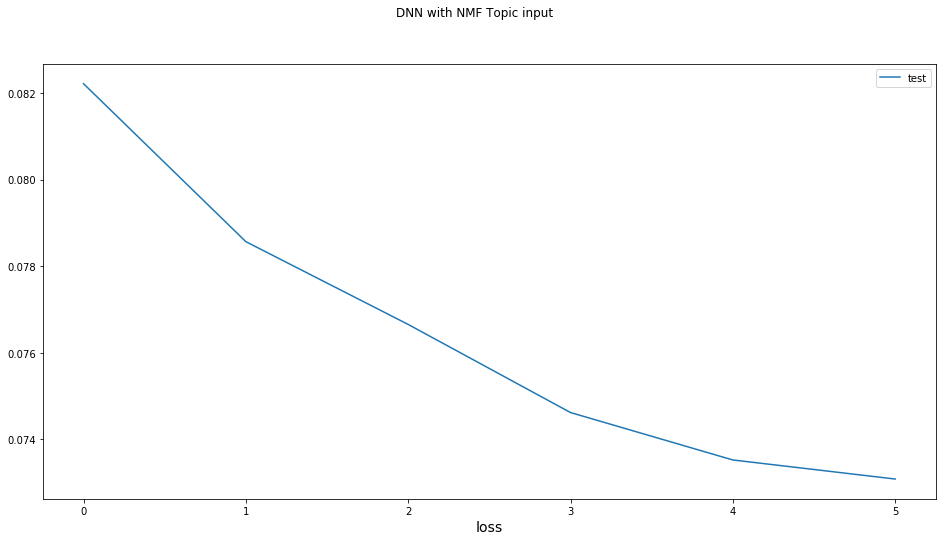

In [77]:
plt.figure(figsize=(16,8))
plt.suptitle("DNN with NMF Topic input")
#plt.subplot(121)
#plt.plot(history_topic_dnn.history['loss'],label='train')
plt.plot(history_topic_dnn.history['val_loss'],label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.xlabel('loss',fontsize=14)
#plt.subplot(122)
#plt.plot(history_topic_dnn.history['acc'],label='train')
# plt.plot(history_topic_dnn.history['val_acc'],label='test')
# plt.legend()
# plt.xlabel('epoch',fontsize=14)
# plt.xlabel('accuracy',fontsize=14)

In [47]:
train_predict = topic_dnn.predict(topics_train)
train_predict.shape

(76680, 6)

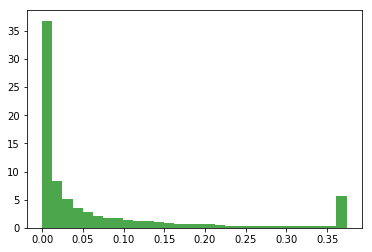

In [55]:
n, bins, patches = plt.hist(train_predict[:,0], 30, normed=1, facecolor='green', alpha=0.7)